In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import pandas as pd
import math

# Parameters set

In [2]:
# parameters

t_max = 180             # シミュレーション日数
dt    = 0.01
pop   = 1000000         # シミュレーション人口（100万人）
b     = 1               # ルーズなb
m     = 0.04            # E→S
g     = 0.2 - m         # E -> I 1/incubtation
dh    = 0.007           # mortality in confirmed case（7%）/infectious period（10日）
rh    = 0.093           # d_i + r_i = Constant(1/infectious period（10日）) 
do    = 0.010           # mortality in unconfirmed case（4%）/infectious period（10日）
ro    = 0.090           # d_o + r_o = Constant(1/infectious period（10日）)

#初期状態

Sh = 1
Eh = 1
Ih = 1
Rh = 0
Dh = 0

So = 999900
Eo = 0
Io = 97
Ro = 0
Do = 0

ini_state = [Sh, Eh, Ih, Rh, Dh, So, Eo, Io, Ro, Do
    ]

# Defining functions

In [3]:
def sigmoid(a):
    e = math.e
    s = 1 / (1 + e**-a)
    return s

In [4]:
def tSEIRD(v, t, a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap):
    beds = np.sum(ini_state) * cap
    return [
        - b * v[0] * v[2]/ (v[0] + v[1] + v[2]) + m * v[1] - a * v[0], #[0] S_h
        b * v[0] * v[2] / (v[0] + v[1] + v[2]) - (m + g) * v[1] + n * (1 - Sp) * v[6] * sigmoid(beds-(v[0]+v[1]+v[2])), #[1] E_h
        g * v[1] - (rh + dh) * v[2] + p * Se * v[7] * sigmoid(beds-(v[0]+v[1]+v[2])), #[2] I_h
        rh * v[2], #[3] R_h
        dh * v[2], #[4] D_h
        - b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) + m * v[6] + a * v[0], #[5] S_o
        b * v[5] * v[7] / (v[5] + v[6] + v[7] + v[8] + v[3]) - (m + g) * v[6] - n * (1 - Sp) * v[6] * sigmoid(beds - (v[0]+v[1]+v[2])) ,#[6] E_o
        g * v[6] - (ro + do) * v[7] - p * Se * v[7] * sigmoid(beds - (v[0]+v[1]+v[2])), #[7] I_o
        ro * v[7], #[8] R_o
        do * v[7] #[9] D_o
                ]

In [5]:
def tSEIRD_matrix(Se,Sp,n,p,cap=0.1,a=0):

    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Sh'] = df[0]# / 1000
    df['Eh'] = df[1]# / 1000
    df['Ih'] = df[2]# / 1000
    df['Rh'] = df[3]# / 1000
    df['Dh'] = df[4]# / 1000
    
    df['So'] = df[5]# / 1000
    df['Eo'] = df[6]# / 1000
    df['Io'] = df[7]# / 1000
    df['Ro'] = df[8]# / 1000
    df['Do'] = df[9]# / 1000
    
    df['Susceptible'] = (df[0] + df[5])# / 1000 #10
    df['Exposed']     = (df[1] + df[6])# / 1000 #11
    df['Infectious']  = (df[2] + df[7])# / 1000 #12
    df['Recovered']   = (df[3] + df[8])# / 1000 #13
    df['Dead']        = (df[4] + df[9])# / 1000 #14

    df['Hospitalised']= (df[0] + df[1] + df[2])# / 1000 #15
    df['Outside']     = (df[3] + df[5] + df[6] + df[7] + df[8])# / 1000 #16
    
    df['TP']          = (p * Se * df[7])# / 1000 #17
    df['FP']          = (n * (1 - Sp) * df[6])# / 1000 #18
    df['Positive']    = df['TP'] + df['FP'] #19

    df['all']         = (df[0]+df[1]+df[2]+df[3]+df[4]+df[5]+df[6]+df[7]+df[8]+df[9])# / 1000 #20
    df['beta_in']     = b / df['Hospitalised'] #21
    df['beta_out']    = b / df['Outside'] #22

    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return df_

In [6]:
def tSEIRD_max(Se,Sp,n,p,cap=0.1,a=0):
    
    times = np.arange(0, t_max, dt)
    args = (a, m, b, g, rh, dh, ro, do, n, p, Se, Sp, cap)

    result = odeint(tSEIRD, ini_state, times, args)

    df = pd.DataFrame(result)
    
    df['Positive'] = (p * Se * df[7]) + (n * (1 - Sp) * df[6])
    df['TP']       = (p * Se * df[7])
    df['FP']       = (n * (1 - Sp) * df[6])

    df['Hospitalised']= df[0] + df[1] + df[2]
    df['Sh'] = df[0]
    df['Eh'] = df[1]
    df['Ih'] = df[2]

    df['Dead']= (df[4] + df[9])
    df['Dh'] = df[4]
    df['Do'] = df[9]
    
    df_ = df.drop([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], axis=1)
    
    return [np.max(df_['Positive']),np.max(df_['Hospitalised']),np.max(df_['Dead'])]

# a = 0.01

In [7]:
v_a = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_a = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_a.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.01))

pos_test_fix_a   = np.array(v_a)[:, 0].reshape((101, 101))
hosp_test_fix_a  = np.array(v_a)[:, 1].reshape((101, 101))
death_test_fix_a = np.array(v_a)[:, 2].reshape((101, 101))

<ipython-input-3-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


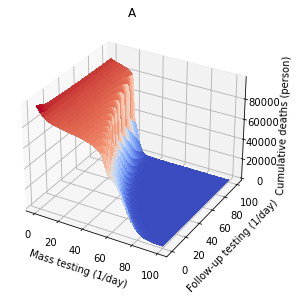

In [9]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_a#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_a))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')#'(1000 persons)')
ax.set_title('A')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# a = 0.03

In [10]:
v_b = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_b = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_b.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.03))

pos_test_fix_b   = np.array(v_b)[:, 0].reshape((101, 101))
hosp_test_fix_b  = np.array(v_b)[:, 1].reshape((101, 101))
death_test_fix_b = np.array(v_b)[:, 2].reshape((101, 101))

<ipython-input-3-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


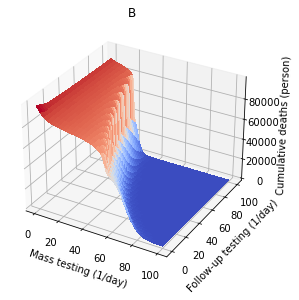

In [11]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_b#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_b))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')#'(1000 persons)')
ax.set_title('B')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# a = 0.1

In [12]:
v_c = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_c = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_c.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.1))

pos_test_fix_c   = np.array(v_c)[:, 0].reshape((101, 101))
hosp_test_fix_c  = np.array(v_c)[:, 1].reshape((101, 101))
death_test_fix_c = np.array(v_c)[:, 2].reshape((101, 101))

<ipython-input-3-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


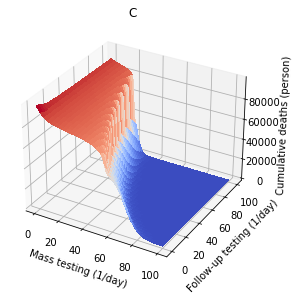

In [13]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_c#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_c))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')#'(1000 persons)')
ax.set_title('C')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

# a = 0.3

In [14]:
v_d = []
# 検査特性固定して受診率変えた場合の最大入院者数、死者数、陽性者数

v_d = []
for i in np.linspace(0,1,101):
    for j in np.linspace(0,1,101):
        v_d.append(tSEIRD_max(0.7,0.7,i,j,0.1,0.3))

pos_test_fix_d   = np.array(v_d)[:, 0].reshape((101, 101))
hosp_test_fix_d  = np.array(v_d)[:, 1].reshape((101, 101))
death_test_fix_d = np.array(v_d)[:, 2].reshape((101, 101))

<ipython-input-3-612ce78b4953>:3: RuntimeWarning: overflow encountered in double_scalars
  s = 1 / (1 + e**-a)


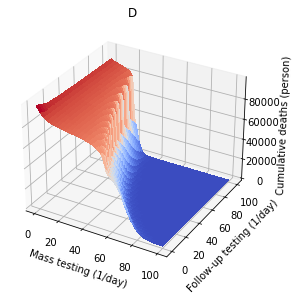

In [15]:
from mpl_toolkits.mplot3d import Axes3D

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

fig = plt.figure()
ax = fig.gca(projection='3d')

X = np.linspace(0, 1, 101)
Y = np.linspace(0, 1, 101)
X, Y = np.meshgrid(X, Y)
Z = death_test_fix_d#/1000

surf = ax.plot_surface(100*X, 100*Y, Z, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False,
                       )

ax.set_zlim(0, np.max(death_test_fix_d))
#ax.set_zlim((np.min(death_test_fix)/1000, np.max(death_test_fix)/1000))

ax.set_xlabel('Mass testing (1/day)')
ax.set_ylabel('Follow-up testing (1/day)')
ax.set_zlabel('Cumulative deaths (person)')#'(1000 persons)')
ax.set_title('D')

# plt.tight_layout()
#plt.savefig('testing_SEIRD_legends/fig_3C.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()

In [ ]:
np.savetxt('v_d.csv',v_d,delimiter=',')

v_d = pd.read_csv('v_d.csv',header=None)

pos_test_fix   = np.array(v_d)[:, 0].reshape((101,101))
hosp_test_fix  = np.array(v_d)[:, 1].reshape((101,101))
death_test_fix = np.array(v_d)[:, 2].reshape((101,101))